In [74]:
import pandas as pd
import numpy as np

from scib_metrics.benchmark import Benchmarker
import scanpy as sc
#adata = sc.read_h5ad('../H19.30.001.STG.4000.expand.rep1.h5ad')
bm = Benchmarker(
    adata,
    batch_key="perturbation",
    label_key="cell_type0528",
    embedding_obsm_keys=["harmony", "contrastivevi_bg", "no_pretraining", "base_ct"],
    pre_integrated_embedding_obsm_key='X_pca',
    n_jobs=6,
)


df = pd.read_csv('slidetag/slidetag_ct.csv',index_col=0)

df = df.drop(columns=['simvi_lz'+str(i) for i in range(10)])
df = df.drop(columns=['simvi_s'+str(i) for i in range(10)])

df = df.T
df['tmp'] = 0
df['tmp'][-1] = 'Batch correction'
df = df.T

bm._results = df
df_ = bm.get_results(min_max_scale=False).T
df_ = df_.T


df2 = pd.read_csv('slidetag/slidetag_niche.csv',index_col=0)

df2 = df2.drop(columns=['simvi_lz'+str(i) for i in range(10)])
df2 = df2.drop(columns=['simvi_z'+str(i) for i in range(10)])



df2 = df2.T
df2['tmp'] = 0
df2['tmp'][-1] = 'Batch correction'
df2 = df2.T

bm._results = df2
df2_ = bm.get_results(min_max_scale=False).T
df2_ = df2_.T

df3 = pd.read_csv('slidetag/slidetag_phase.csv',index_col=0)

df3 = df3.drop(columns=['simvi_lz'+str(i) for i in range(10)])
df3 = df3.drop(columns=['simvi_z'+str(i) for i in range(10)])

df3 = df3.T
df3['tmp'] = 0
df3['tmp'][-1] = 'Batch correction'
df3 = df3.T

bm._results = df3
df3_ = bm.get_results(min_max_scale=False).T
df3_ = df3_.T

df_.index = [col.replace('simvi_z', 'simvi_d') if 'simvi_z' in col else col for col in df_.index]
df2_.index = [col.replace('simvi_s', 'simvi_d') if 'simvi_s' in col else col for col in df2_.index]
df3_.index = [col.replace('simvi_', 'simvi_d') if 'simvi_' in col else col for col in df3_.index]

df_f = pd.merge(df_[['Bio conservation']],df2_[['Bio conservation']],left_index=True,right_index=True)
df_f = pd.merge(df_f,df3_[['Bio conservation']],left_index=True,right_index=True)


def nmlz(x):
    #return (x - x.min())/(x.max() - x.min())
    return x

df_f['Total'] = 0

df_f['Total'][:-1] = (1/3) * (nmlz(df_f['Bio conservation_x'].values[:-1]) + nmlz(df_f['Bio conservation_y'].values[:-1]) + nmlz(df_f['Bio conservation'].values[:-1]))
df_f['Total_rescaled'] = 0
df_f['Total_rescaled'][:-1] = (df_f['Total'][:-1] - df_f['Total'][:-1].min()) / (df_f['Total'][:-1].max() - df_f['Total'][:-1].min())

df_f['name'] = df_f.index.str[:-1]
df_summary_mean = df_f.iloc[:-1].groupby('name').mean()
df_summary_std = df_f.iloc[:-1].groupby('name').std()
#df_summary_mean


df_summary_mean = df_summary_mean.iloc[[5,0,1,4,3,9,7,8,6]]
df_summary_std = df_summary_std.iloc[[5,0,1,4,3,9,7,8,6]]

df_summary_mean.index=['scVI','GraphST','STAGATE','NSF','CellCharter','SpiceMix','Graph Only','Graph Only + cell type (NCEM)', 'SIMVI']
df_summary_std.index = df_summary_mean.index

df_summary_mean.columns = ['Cell type\nscore','SIMVI\nniche score','GC phase\n score','Total\n score'+r'$^\dagger$','Total\n score*']
df_summary_std.columns = ['Cell type\nscore','SIMVI\nniche score','GC phase\n score','Total\n score'+r'$^\dagger$','Total\n score*']

df_summary_mean = df_summary_mean.iloc[:,[0,1,2,4]]
df_summary_std = df_summary_std.iloc[:,[0,1,2,4]]
df_summary_ste = df_summary_std / np.sqrt(10)

/var/folders/lh/5h3qxqln0dlfw494qsg03jcc0000gn/T/ipykernel_73629/685365669.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tmp'][-1] = 'Batch correction'
/var/folders/lh/5h3qxqln0dlfw494qsg03jcc0000gn/T/ipykernel_73629/685365669.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['tmp'][-1] = 'Batch correction'
/var/folders/lh/5h3qxqln0dlfw494qsg03jcc0000gn/T/ipykernel_73629/685365669.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-

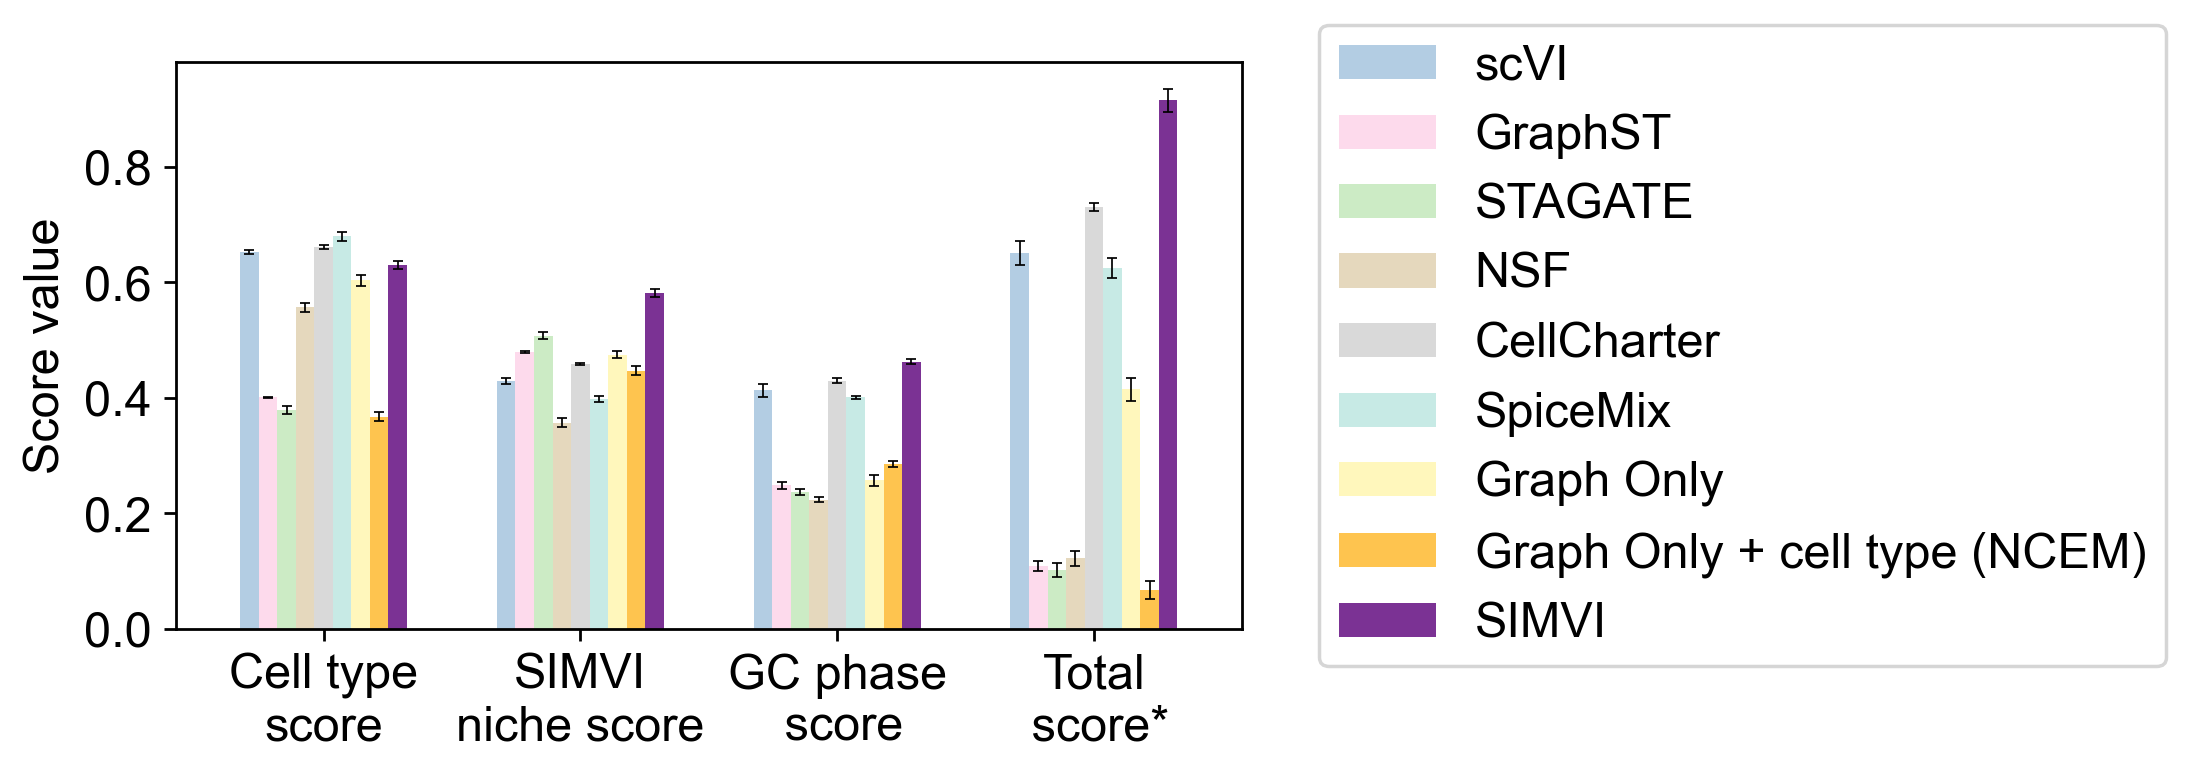

In [75]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = 'Arial'
plt.rcParams['figure.dpi'] = 250
plt.rcParams["font.size"] = 14
fig, axs = plt.subplots(figsize=(4,2))
error_bar_style = {'elinewidth': 0.5, 
                   'ecolor': 'black',  
                   'capsize': 1.5,     
                   'capthick': 0.5}    

color_list = ['#b3cde3','#fddaec','#ccebc5','#e5d8bd','#d9d9d9','#c7eae5','#fff7bc','#fec44f','#7b3294']
df_summary_mean.T.plot(kind="bar",rot=0,edgecolor='none',color=color_list,figsize=(5.5,3),ax=axs,yerr=df_summary_ste.T, error_kw=error_bar_style,width=0.65)
axs.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
axs.set_ylabel('Score value')
plt.savefig('slidetag_benchmarking_main.pdf',bbox_inches='tight')